---
# Imports

In [1]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import pyspark

In [2]:
spark = SparkSession.builder.appName("ProjetoABD").getOrCreate()

In [ ]:
dados = spark.read.load('avioes/raw',format='csv',sep=',',inferSchema=True, header=True)

In [4]:
dados.printSchema()
dados.show()
dados.count()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- FlightDate: date (nullable = true)
 |-- Marketing_Airline_Network: string (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- DOT_ID_Marketing_Airline: integer (nullable = true)
 |-- IATA_Code_Marketing_Airline: string (nullable = true)
 |-- Flight_Number_Marketing_Airline: integer (nullable = true)
 |-- Originally_Scheduled_Code_Share_Airline: string (nullable = true)
 |-- DOT_ID_Originally_Scheduled_Code_Share_Airline: integer (nullable = true)
 |-- IATA_Code_Originally_Scheduled_Code_Share_Airline: string (nullable = true)
 |-- Flight_Num_Originally_Scheduled_Code_Share_Airline: integer (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- DOT_ID_Operating_Airline: integer (nullable = true)
 |-- IATA_Code_Operating_A

29193782

-----
# Data Cleaning

## 1.Removing duplicates if any

In [ ]:
print(f'Dados: number of rows: {dados.count()}, after dropduplicates: {dados.dropDuplicates().count() }')

## 2.Removing useless columns

In [5]:
cols_to_dismiss = [
    # Informações duplicadas ou derivadas
    'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups',
    'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
    'DepTimeBlk','ArrTimeBlk','DestAirportID','DestAirportSeqID',
    'DestCityMarketID','OriginAirportID','OriginAirportSeqID',
    'OriginCityMarketID','Marketing_Airline_Network',
    'Operating_Airline','Flight_Number_Marketing_Airline',
    'FlightDate','OriginWac','DestWac','Flights',
    'Duplicate',"OriginStateFips","DestStateFips",'OriginState',
    "DestState",

    # Diverted flights – detalhes específicos desnecessários
    'DivAirportLandings', 'DivReachedDest', 'DivActualElapsedTime',
    'DivArrDelay', 'DivDistance',

    # Todas as colunas relacionadas com aeroportos desviados 
    'Div1Airport', 'Div1AirportID', 'Div1AirportSeqID', 'Div1WheelsOn',
    'Div1TotalGTime', 'Div1LongestGTime', 'Div1WheelsOff', 'Div1TailNum',
    'Div2Airport', 'Div2AirportID', 'Div2AirportSeqID', 'Div2WheelsOn',
    'Div2TotalGTime', 'Div2LongestGTime', 'Div2WheelsOff', 'Div2TailNum',
    'Div3Airport', 'Div3AirportID', 'Div3AirportSeqID', 'Div3WheelsOn',
    'Div3TotalGTime', 'Div3LongestGTime', 'Div3WheelsOff', 'Div3TailNum',
    'Div4Airport', 'Div4AirportID', 'Div4AirportSeqID', 'Div4WheelsOn',
    'Div4TotalGTime', 'Div4LongestGTime', 'Div4WheelsOff', 'Div4TailNum',
    'Div5Airport', 'Div5AirportID', 'Div5AirportSeqID', 'Div5WheelsOn',
    'Div5TotalGTime', 'Div5LongestGTime', 'Div5WheelsOff', 'Div5TailNum',

    # Identificadores redundantes
    'DOT_ID_Marketing_Airline', 'DOT_ID_Operating_Airline','DayofMonth',
    'IATA_Code_Marketing_Airline', 'IATA_Code_Operating_Airline','Tail_Number',

    #dados com mts nulls
    'CancellationCode','Originally_Scheduled_Code_Share_Airline','DOT_ID_Originally_Scheduled_Code_Share_Airline',
    'IATA_Code_Originally_Scheduled_Code_Share_Airline','Flight_Num_Originally_Scheduled_Code_Share_Airline','CarrierDelay',
    'WeatherDelay','NASDelay','SecurityDelay','FirstDepTime','TotalAddGTime','LongestAddGTime','_c119','LateAircraftDelay'
]

dados = dados.drop(*cols_to_dismiss)

In [6]:
dados.printSchema()
dados.show()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- DepDelay: double (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- ArrDelay: double (nullable

## Data transformation

In [7]:
# Converter hhmm para minutos
def hhmm_to_minutes(col):
    return (F.floor(col / 100) * 60) + (col % 100)

# Tempos de partida
dados = dados.withColumn("DepTime", hhmm_to_minutes(F.col("DepTime")))
dados = dados.withColumn("CRSDepTime", hhmm_to_minutes(F.col("CRSDepTime")))
dados = dados.withColumn("DepDelay",F.col("DepTime") - F.col("CRSDepTime"))

# Tempos de chegada
dados = dados.withColumn("ArrTime", hhmm_to_minutes(F.col("ArrTime")))
dados = dados.withColumn("CRSArrTime", hhmm_to_minutes(F.col("CRSArrTime")))
dados = dados.withColumn("ArrDelay", F.col("ArrTime") - F.col("CRSArrTime"))
# F.greatest(F.col("ArrTime") - F.col("CRSArrTime"), F.lit(0))

In [8]:
# Meter a localizaçao da partida e destino numa só tabela
dados = dados.withColumn('OriginCityNameState',
                          F.concat_ws(
                              ',',
                                F.split(F.col('OriginCityName'),',')[0],
                                F.col("OriginStateName")
    ))

dados = dados.withColumn('DestCityNameState',
                          F.concat_ws(
                              ',',
                                F.split(F.col('DestCityName'),',')[0],
                                F.col("DestStateName")
    ))

cols_to_dismiss = ["OriginCityName","OriginStateName","DestCityName","DestStateName"]
dados = dados.drop(*cols_to_dismiss)

In [ ]:
dados = dados.withColumnRenamed("Operating_Airline ","Operating_Airline")

In [9]:
dados.printSchema()
dados.show()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: long (nullable = true)
 |-- DepDelay: long (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: long (nullable = true)
 |-- ArrDelay: long (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime:

## 3.Handling missing values

In [ ]:
# Ver em que colunas estão os nulos (by columns)
nulls = {col: dados.filter(dados[col].isNull()).count() for col in dados.columns}
nulls

# valores corridos ao dataset todo sem fazer nada aos nulls
'''
{'Year': 0,
 'Quarter': 0,
 'Month': 0,
 'DayOfWeek': 0,
 'Operated_or_Branded_Code_Share_Partners': 0,
 'Operating_Airline ': 0,
 'Flight_Number_Operating_Airline': 0,
 'Origin': 0,
 'Dest': 0,
 'CRSDepTime': 0,
 'DepTime': 761652,
 'DepDelay': 761652,
 'TaxiOut': 780561,
 'WheelsOff': 780551,
 'WheelsOn': 793133,
 'TaxiIn': 793143,
 'CRSArrTime': 0,
 'ArrTime': 786177,
 'ArrDelay': 786177,
 'Cancelled': 0,
 'Diverted': 0,
 'CRSElapsedTime': 22,
 'ActualElapsedTime': 845637,
 'AirTime': 852561,
 'Distance': 0,
 'DistanceGroup': 0,
 'OriginCityNameState': 0,
 'DestCityNameState': 0}
'''

In [10]:
# remover nulls
dados = dados.dropna(how='any')

In [11]:
dados.printSchema()
dados.show()
dados.count()

root
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- Operated_or_Branded_Code_Share_Partners: string (nullable = true)
 |-- Operating_Airline : string (nullable = true)
 |-- Flight_Number_Operating_Airline: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- CRSDepTime: long (nullable = true)
 |-- DepTime: long (nullable = true)
 |-- DepDelay: long (nullable = true)
 |-- TaxiOut: double (nullable = true)
 |-- WheelsOff: integer (nullable = true)
 |-- WheelsOn: integer (nullable = true)
 |-- TaxiIn: double (nullable = true)
 |-- CRSArrTime: long (nullable = true)
 |-- ArrTime: long (nullable = true)
 |-- ArrDelay: long (nullable = true)
 |-- Cancelled: double (nullable = true)
 |-- Diverted: double (nullable = true)
 |-- CRSElapsedTime: double (nullable = true)
 |-- ActualElapsedTime: double (nullable = true)
 |-- AirTime:

28341220

-----
# Gráficos

### Matriz de correlação

In [ ]:
# colunas numericas
input_cols_num = [
    "Year",
    "Quarter",
    "Month",
    "DayOfWeek",
    "Flight_Number_Operating_Airline",
    "CRSDepTime",
    "DepTime",
    "DepDelay",
    "TaxiOut",
    "WheelsOff",
    "Distance",
    "DistanceGroup",
    "AirTime",
    "CRSArrTime",
    "ArrTime",
    "ArrDelay",
    "WheelsOn",
    "TaxiIn",
    "Cancelled",
    "Diverted",
    "CRSElapsedTime",
    "ActualElapsedTime"
]


# colunas categoricas
input_cols_str = [
    "Operated_or_Branded_Code_Share_Partners",
    "Operating_Airline",
    "Origin",
    "Dest",
    "OriginCityNameState",
    "DestCityNameState"
]

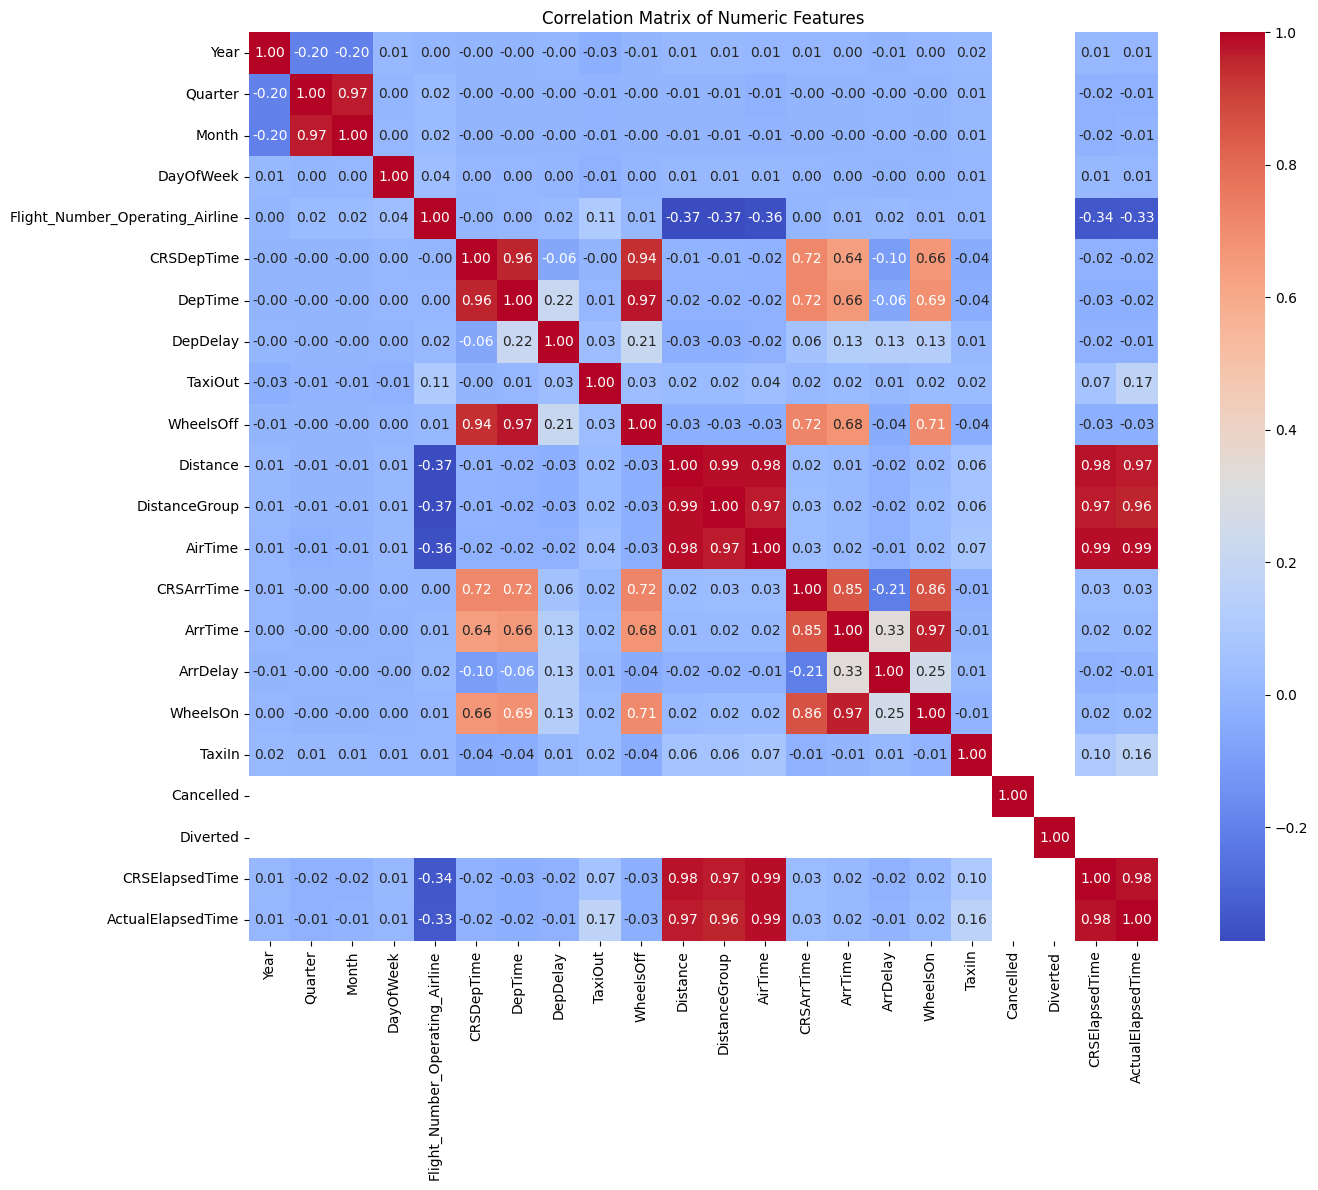

In [ ]:
assembler = VectorAssembler(inputCols=input_cols_num, outputCol="numeric_features")
numeric_df = assembler.transform(dados).select("numeric_features")

correlation_matrix = Correlation.corr(numeric_df, "numeric_features", "pearson").head()[0].toArray()

corr_df = pd.DataFrame(correlation_matrix, columns=input_cols_num, index=input_cols_num)

plt.figure(figsize=(15, 12))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Matriz de correlação das features numericas")
plt.tight_layout()
plt.show()

### cenas do dia da semana

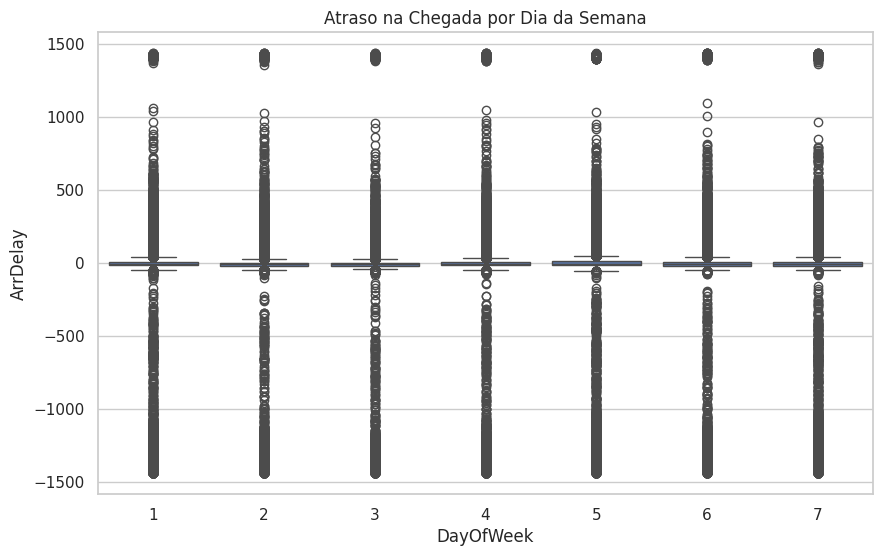

/tmp/ipykernel_42001/2295507483.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=contagem, x='DayOfWeek', y='QtdAtrasos', palette='Blues_d')


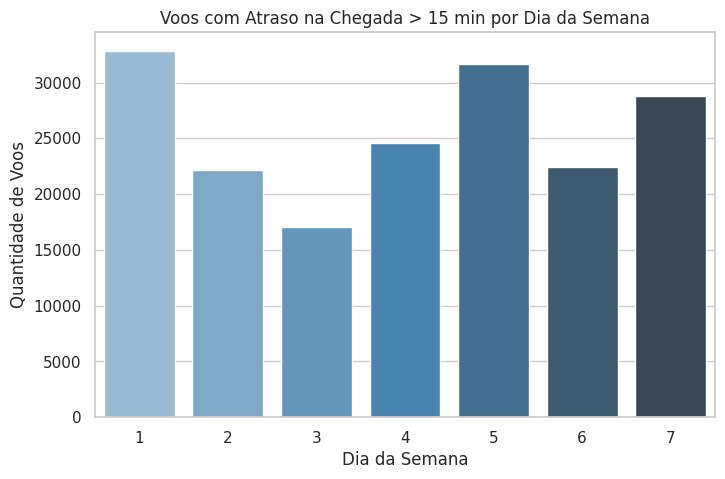

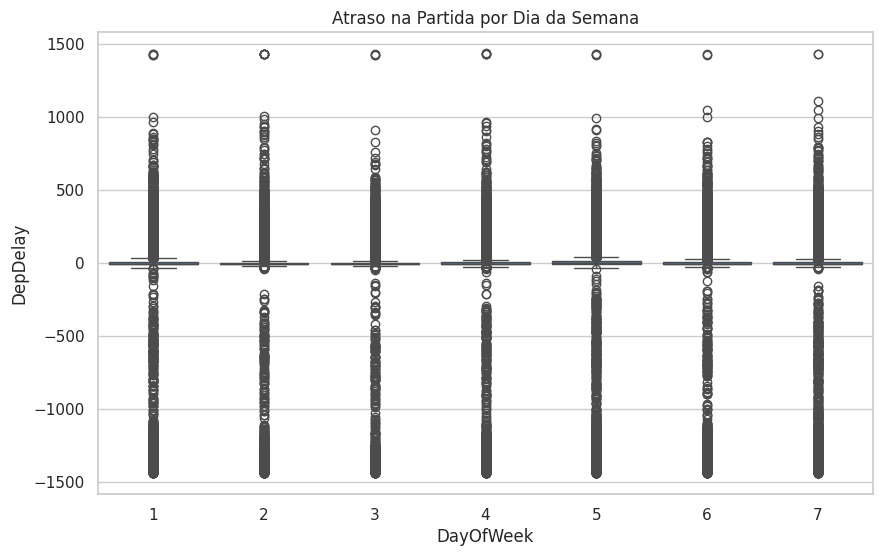

/tmp/ipykernel_42001/2295507483.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=contagem, x='DayOfWeek', y='QtdAtrasos', palette='Blues_d')


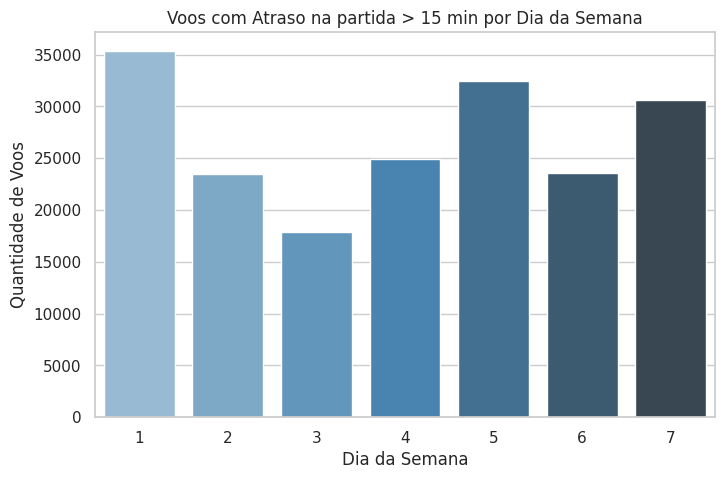

In [16]:
df_small = dados.limit(1000000)
df = df_small.toPandas()

sns.set(style="whitegrid")



plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='DayOfWeek', y='ArrDelay')
plt.title('Atraso na Chegada por Dia da Semana')
plt.show()

df_filtrado = df[df['ArrDelay'] > 15]
contagem = df_filtrado.groupby('DayOfWeek').size().reset_index(name='QtdAtrasos')

plt.figure(figsize=(8, 5))
sns.barplot(data=contagem, x='DayOfWeek', y='QtdAtrasos', palette='Blues_d')
plt.title('Voos com Atraso na Chegada > 15 min por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Voos')
plt.show()



plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='DayOfWeek', y='DepDelay')
plt.title('Atraso na Partida por Dia da Semana')
plt.show()


df_filtrado = df[df['DepDelay'] > 15]
contagem = df_filtrado.groupby('DayOfWeek').size().reset_index(name='QtdAtrasos')

plt.figure(figsize=(8, 5))
sns.barplot(data=contagem, x='DayOfWeek', y='QtdAtrasos', palette='Blues_d')
plt.title('Voos com Atraso na partida > 15 min por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Voos')
plt.show()

### KMeans

In [ ]:
# Encode das colunas categoricas
available_cols = set(dados.columns)
indexers = [StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid='keep')
            for col in input_cols_str if col in available_cols]

# juntar as colunas
assembler = VectorAssembler(
    inputCols=[
    "Year","Quarter","Month","DayOfWeek","Flight_Number_Operating_Airline","CRSDepTime","DepTime","TaxiOut",
    "WheelsOff","Distance","DistanceGroup","AirTime","CRSArrTime","ArrTime","WheelsOn","TaxiIn","Cancelled",
    "Diverted","CRSElapsedTime","ActualElapsedTime","Origin_Index", "Dest_Index","Operating_Airline_Index",
    "Operated_or_Branded_Code_Share_Partners_Index", "OriginCityNameState_Index","DestCityNameState_Index"
    ],
    outputCol="features_unscaled"
)

scaler = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
kmeans = KMeans(k=5, seed=1, featuresCol="features", predictionCol="cluster")
pipeline = Pipeline(stages=indexers + [assembler, scaler, kmeans])

# correr o modelo
model = pipeline.fit(dados)
clustered_df = model.transform(dados)

print("KMeans feito")

# Ver a média do delay
clustered_df.groupBy("cluster").agg(
    {"DepDelay": "avg", "ArrDelay": "avg"}
).show()

KMeans feito
+-------+-------------------+-------------------+
|cluster|      avg(DepDelay)|      avg(ArrDelay)|
+-------+-------------------+-------------------+
|      1|-1.8586868597626622| -19.75118491686404|
|      3|  12.87206845472596|-12.388121907403322|
|      4|  6.102596653600298|-1.8915797745476939|
|      2| 3.6416152699597655| -19.84954100941574|
|      0|-3.6392499761687187| -9.450731086180486|
+-------+-------------------+-------------------+



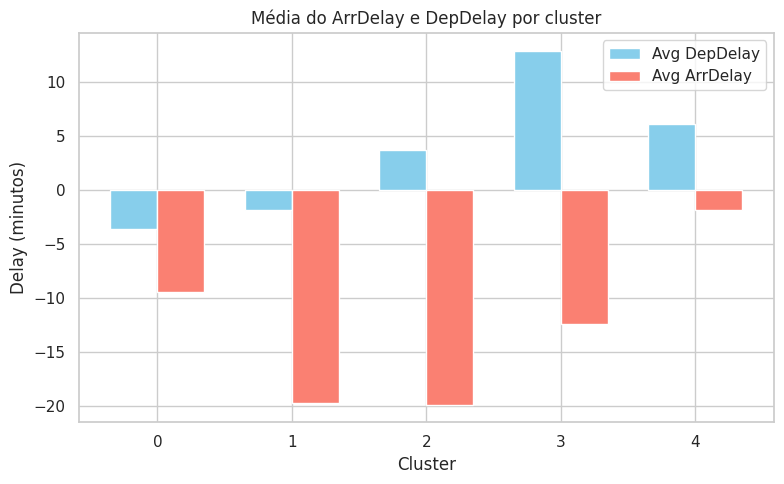

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

delay_summary = clustered_df.groupBy("cluster").agg(
    {"DepDelay": "avg", "ArrDelay": "avg"}
).toPandas()

x = delay_summary["cluster"]
width = 0.35

ax.bar(x - width/2, delay_summary["avg(DepDelay)"], width, label="Avg DepDelay", color='skyblue')
ax.bar(x + width/2, delay_summary["avg(ArrDelay)"], width, label="Avg ArrDelay", color='salmon')

ax.set_xlabel("Cluster")
ax.set_ylabel("Delay (minutos)")
ax.set_title("Média do ArrDelay e DepDelay por cluster")
ax.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

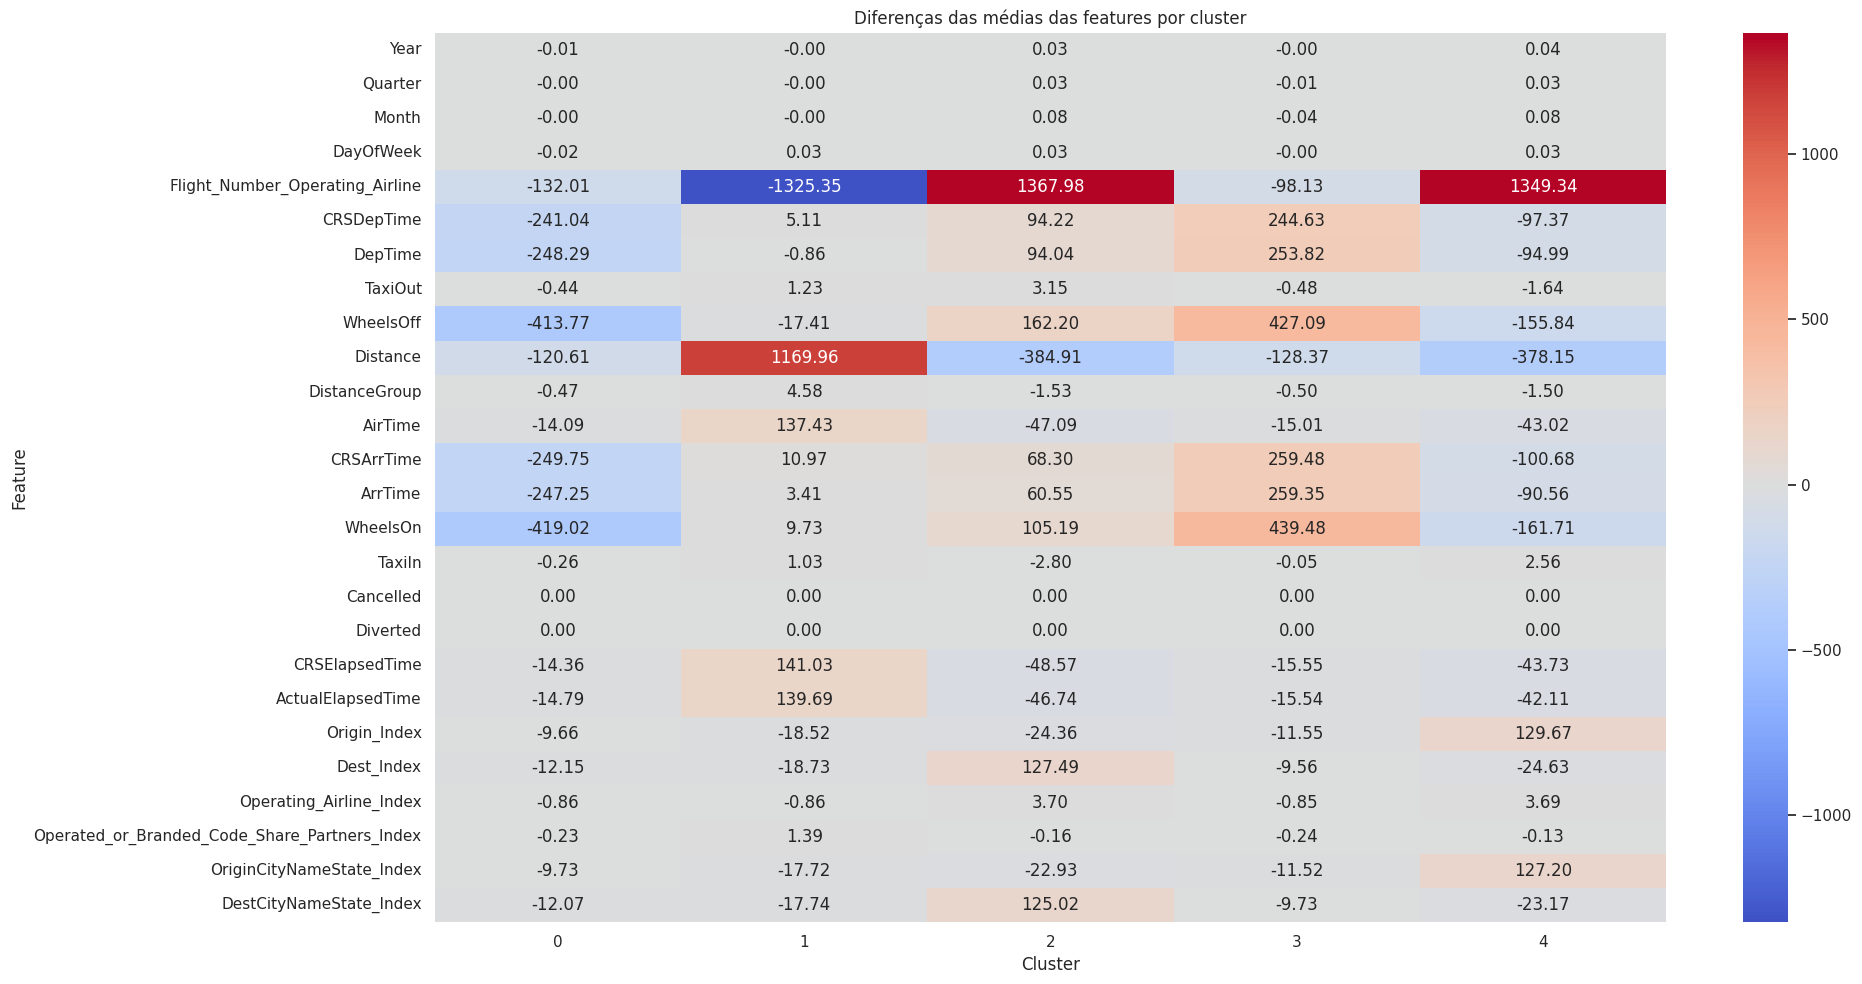

In [32]:
# features dos clusters mais os clusters
cols_to_collect = [
    "Year","Quarter","Month","DayOfWeek","Flight_Number_Operating_Airline","CRSDepTime",
    "DepTime","TaxiOut","WheelsOff","Distance","DistanceGroup","AirTime","CRSArrTime",
    "ArrTime","WheelsOn","TaxiIn","Cancelled","Diverted","CRSElapsedTime","ActualElapsedTime",
    "Origin_Index","Dest_Index","Operating_Airline_Index","Operated_or_Branded_Code_Share_Partners_Index",
    "OriginCityNameState_Index","DestCityNameState_Index","cluster"
]

sampled = clustered_df.select(*cols_to_collect).sample(fraction=0.05, seed=42)
pdf = sampled.toPandas()

global_mean = pdf.drop(columns=["cluster"]).mean()
cluster_means = pdf.groupby("cluster").mean()

differences = cluster_means - global_mean

plt.figure(figsize=(20, 10))
sns.heatmap(differences.T, cmap="coolwarm", center=0, annot=True, fmt=".2f")
plt.title("Diferenças das médias das features por cluster")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

### Relevância das features

In [25]:
categorical_cols = [
    #"Operated_or_Branded_Code_Share_Partners",
    "Operating_Airline",
    "Origin",
    "Dest",
    #"OriginCityNameState",
    #"DestCityNameState"
]

indexers = [StringIndexer(inputCol=c, outputCol=c + "_Index", handleInvalid="keep") 
            for c in categorical_cols]


all_features = [
    "CRSDepTime", "DepTime", "TaxiOut", "WheelsOff", "WheelsOn", "TaxiIn",
    "CRSArrTime", "ArrTime", "AirTime", "Distance", "CRSElapsedTime", "ActualElapsedTime",
    "Year","Quarter","Month", "DayOfWeek"
] + [c + "_Index" for c in categorical_cols]

assembler = VectorAssembler(inputCols=all_features, outputCol="features")

In [26]:
rf = RandomForestRegressor(featuresCol="features", labelCol="DepDelay", numTrees=40, seed=42,maxBins=400)
pipeline = Pipeline(stages=indexers + [assembler, rf])

rf_model = pipeline.fit(dados)
importances = rf_model.stages[-1].featureImportances.toArray()

/tmp/ipykernel_42001/2150850221.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_series.values, y=importance_series.index, palette="magma")


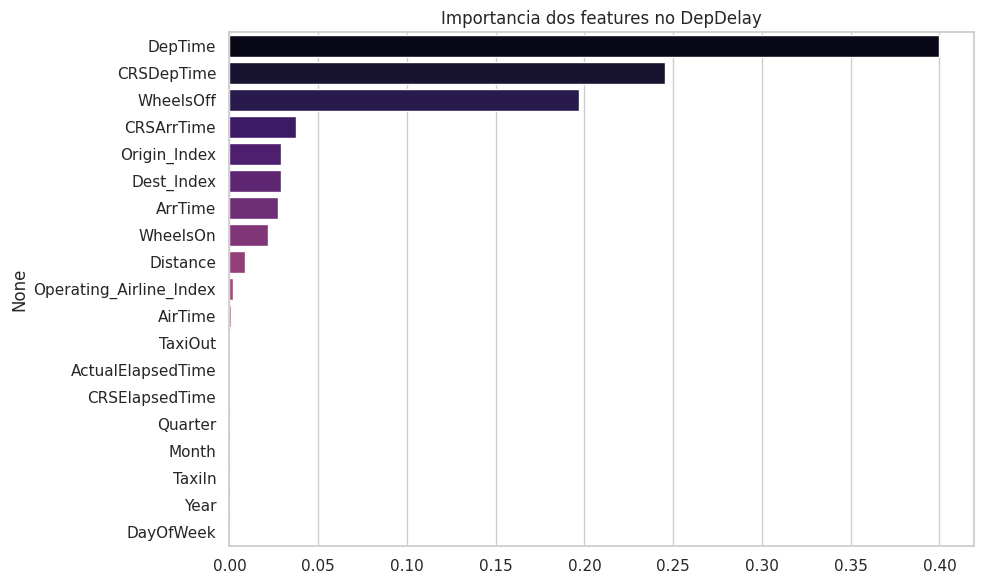

In [27]:
feature_names = all_features
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_series.values, y=importance_series.index, palette="magma")
plt.title("Importancia dos features no DepDelay")
plt.tight_layout()
plt.show()

In [28]:
rf = RandomForestRegressor(featuresCol="features", labelCol="ArrDelay", numTrees=40, seed=42,maxBins=400)
pipeline = Pipeline(stages=indexers + [assembler, rf])

rf_model = pipeline.fit(dados)
importances = rf_model.stages[-1].featureImportances.toArray()

/tmp/ipykernel_42001/3172157240.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_series.values, y=importance_series.index, palette="magma")


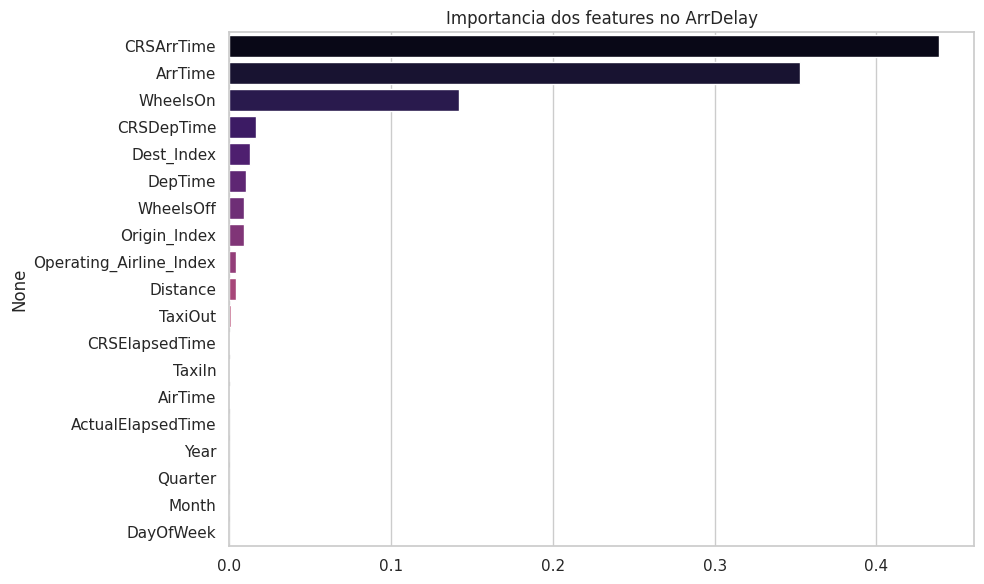

In [29]:
feature_names = all_features
importance_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_series.values, y=importance_series.index, palette="magma")
plt.title("Importancia dos features no ArrDelay")
plt.tight_layout()
plt.show()